# Best Grades 
#### Project by Ran Benayoun

## Project Description

This project scrapes the histogram database from Cheesefork's GitHub repository.

It enables analysis of:
- The **average median grade** for each course
- The **maximum grade** recorded in each course

## Limitations

- The statistics are based only on **available histograms**. Courses with no histograms (typically those with under 10 students or no shared data) are **not included** in the analysis.
- **Course numbers change occasionally**, which can result in data loss or duplication.
- In **2024**, the Technion changed course numbers from 6 digits to 7 or 8 digits. This created inconsistencies in the dataset.


In [1]:
# All the imports needed for the script to function properly
import re
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import requests
from tqdm import tqdm
from time import sleep
import csv

In [15]:
#Defing functions needed for the script

def find_6_digit_sequences(input_string):
    """
    for catalogs older than 2024
    Finds all unique 6-digit sequences in a given string.

    Args:
        input_string (str): The string to search for 6-digit sequences.

    Returns:
        list: A list of unique 6-digit sequences found in the input string.
    """
    # Define the regex pattern to match 6-digit sequences
    pattern = r'\b\d{6}\b'
    
    # Find all matches using findall() method
    sequences = re.findall(pattern, input_string)
    
    return sequences

def find_7_digit_sequences(input_string):
    """
    for catalogs newer than 2024
    Finds all unique 7-digit sequences in a given string.

    Args:
        input_string (str): The string to search for 76-digit sequences.

    Returns:
        list: A list of unique 7-digit sequences found in the input string.
    """
    # Define the regex pattern to match 7-digit sequences
    pattern = r'\b\d{7}\b'
    
    # Find all matches using findall() method
    sequences = re.findall(pattern, input_string)
    
    return sequences

def clean_string(input_string):
    """
    Cleans a string by removing double quotes, single quotes, new lines, 
    carriage returns, and excessive spaces.

    Args:
        input_string (str): The string to be cleaned.

    Returns:
        str: The cleaned string.
    """
    # Replace unwanted characters
    cleaned_string = input_string.replace('"', '').replace("'", '').replace('\n', ' ').replace('\r', ' ')
    
    # Remove leading and trailing whitespace
    cleaned_string = cleaned_string.strip()
    
    # Remove excessive spaces between words
    cleaned_string = ' '.join(cleaned_string.split())
    
    return cleaned_string

def add_to_catalog_file(filename):
    """
    Adds new catalog data to an existing JSON file through one-time user input. 
    If the file does not exist, it creates a new one.

    Args:
        filename (str): The name of the JSON file to be updated or created.

    Example:
        add_to_catalog_file("catalogs.json")
    """
    # Load existing data
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            existing_catalogs = json.load(f)
    else:
        existing_catalogs = {}

    # Get user input for new catalog entries
    print("Enter your catalog entries (type 'done' when finished):")
    while True:
        catalog_name = input("Catalog name: ")
        if catalog_name.lower() == 'done':
            break
        catalog_content = []
        print("Enter the catalog content (type 'done' on a new line when finished):")
        while True:
            line = input()
            if line.lower() == 'done':
                break
            catalog_content.append(line)
        catalog_content = '\n'.join(catalog_content)
        
        existing_catalogs[catalog_name] = catalog_content

    # Save the updated data back to the JSON file
    with open(filename, 'w') as f:
        json.dump(existing_catalogs, f, indent=4)

# Loading the updated catalogs to verify
def load_catalog_file(filename):
    """
    Loads a JSON file and returns the catalog data as a dictionary.

    Args:
        filename (str): The name of the JSON file to be loaded.

    Returns:
        dict: A dictionary containing the catalog data.
    """
    with open(filename, 'r') as f:
        catalogs = json.load(f)
    return catalogs

def plot_bar_chart_with_trendline(average_medians, save_path=None):
    """
    Plots a bar chart of the average medians with a trendline.
    
    Args:
        average_medians (dict): Dictionary with course numbers as keys and average median values as values.
        save_path (str, optional): If provided, saves the figure to the given path.
    """
    # Filter out None values
    courses = [course for course, median in average_medians.items() if median is not None]
    medians = [median for median in average_medians.values() if median is not None]

    plt.figure(figsize=(10, 6))
    plt.bar(courses, medians, color='skyblue', label='Average Median')

    # Add trendline
    x = np.arange(len(courses))
    z = np.polyfit(x, medians, 1)
    p = np.poly1d(z)
    plt.plot(courses, p(x), "r--", label='Trendline')

    plt.title('Bar Plot of Average Medians by Course Number')
    plt.xlabel('Course Number')
    plt.ylabel('Average Median')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Figure saved to {save_path}")

    plt.show()

Adding catalog entries through the scripts:

In [23]:
add_to_catalog_file("catalogs.json")

Enter your catalog entries (type 'done' when finished):
Enter the catalog content (type 'done' on a new line when finished):
Enter the catalog content (type 'done' on a new line when finished):


In [7]:
#loaging the updated catalogs to verify
catalog = load_catalog_file("catalogs.json")

View the content of the catalogs:

In [8]:
for catalog_name, catalog_content in catalog.items():
    print(f"{catalog_name}: {catalog_content}")

hova_2023:  "044102 למשח תודבעמב תוחיטב 4 - - 0.0 104065 הרבגלא 1מ2 4 2 - 5.0 104042 ודח 1מ2 4 2 - 5.0 114071 הקיזיפ 1 'מ 3 1 - 3.5 125001  הימיכ תיללכ 2 2 - 3.0 134058 104013 אודח 2ת 4 3 - 5.5 104038 הרבגלא 2מ 2 1 - 2.5 104136 רדמ  3 2 - 4.0 114052 הקיזיפ 2 3 1 - 3.5 124801 תינגרוא הימיכ 1 ב 2 1 - 2.5 234128 044105 םיילמשחה םילגעמה תרות 3 2 - 4.0 104214 הירופ ירוט 2 1 - 2.5 104215 תובכורמ תויצקנופ 2 1 - 2.5 104220 דמ 2 1 - 2.5 124503 תילקיזיפ הימיכ 1ב 2 1 - 2.5 134019 היגולומיזנאו הימיכויבל אובמ 2 1 - 2.5 334274 044131 תוכרעמו תותוא 4 2 - 5.0 104034 ח תורבתסהל אובמ 3 3 - 3.5 334221 לש תודוסי םירמוח םייאופר 2 1 - 2.5 334222 םיקצומ תקינכמ ויב הסדנהל - תיאופר 3 2 - 4.0 336537 134113 םיילובטמ םילולסמ 3 1 - 3.5 276011 םיסדנהמל ףוגה תוכרעמ לש היגולויזיפ 3 1 - 3.5 334009 םייגולויב םימרוז תקינכמ 3 2 - 4.0 334011 ויב ןכת תודוסי - ילמשח 3 2 - 4.0 335010 יסיסב ינכמויב ןכת 2 2 - 3.0 336022 334023 הקיטסיטטסל אובמ 3 1 - 3.5 335001 334014 ויב הסדנהב טקיורפ - תיאופר 1 - - 9 4.0 335002 335015 ויב הסדנ

Load the BME mandatory courses and add a leading "0" for formatting according to Cheesfork data

In [9]:
hova_2024 = find_7_digit_sequences(clean_string(catalog['hova_2024']))
hova_2024 = ["0" + s for s in hova_2024]
print(hova_2024)


['00440102', '01040065', '01040042', '01140071', '01250001', '01340058', '03340021', '01040042', '01040018', '01040065', '01040016', '01040013', '01040038', '01040136', '01140052', '01240801', '02340128', '00440105', '01040214', '01040215', '01040220', '01240503', '01340019', '03340274', '03240033', '00440131', '01040034', '03340221', '03340222', '03360537', '01340113', '03340009', '03340011', '03350010', '03360022', '03360100', '03340023', '03350001', '03340014', '03350002', '03360026', '03350015', '03350003']


In [18]:
#Helps to know what changed each year
def compare_lists(list1, list2):
    differences = {
        "only_in_list1": [item for item in list1 if item not in list2],
        "only_in_list2": [item for item in list2 if item not in list1],
        "in_both": [item for item in list1 if item in list2]
    }
    return differences

hova2018 = find_6_digit_sequences(clean_string(catalog['hova_2018']))
hova2019 = find_6_digit_sequences(clean_string(catalog['hova_2019']))
hova2020 = find_6_digit_sequences(clean_string(catalog['hova_2020']))
hova2021 = find_6_digit_sequences(clean_string(catalog['hova_2021']))
hova2022 = find_6_digit_sequences(clean_string(catalog['hova_2022']))
hova2023 = find_6_digit_sequences(clean_string(catalog['hova_2023']))

#compare_lists(hova2019, hova2023)

In [ ]:
#Setting up "Megamot" course lists for core courses (have to pick at least 2) and the rest of the courses.
#This list fits the catalog in 2023. any catalog after 2024 includes "Biophysics" and have very different lists.

#loading biomechanics courses from the catalog
mech = find_6_digit_sequences(clean_string(catalog['biomechanics']))
#splitting into mandetory and electives - Biomechanics
mech_core = mech[:6]
mech_rest = mech[6:]

#Setting up signal processing course lists for core courses (have to pick at least 2) and the rest of the courses.
sig_core = ["336020","336023","336027","336208","336326","336502","336522","336533"]
sig_rest =["336325","336504","336521","336536","336538","336540","336544","336545","336546","336547","336549","336550","034033","044101","044198","044202","046195","046197","046200","046201","046211","046332","046745","046746","236523","236781"]
#splitting into mandetory and electives - Tissue engineering
rekamot = find_6_digit_sequences(clean_string(catalog['Tissue']))
tissue_core = rekamot[:5]
tissue_rest = rekamot[5:]

This code goes through the list of courses and extract all the stats from Cheesfork's GitHub while showing a progress bar - got to be patient

In [10]:
def get_finals_statistics(course_numbers, access_token):
    """
    Fetches the finals statistics for the given course numbers from GitHub.

    Args:
        course_numbers (list of str): List of course numbers to fetch statistics for.
        access_token (str): GitHub access token for authentication.

    Returns:
        dict: A dictionary containing the statistics for each course.
    """
    base_url = "https://api.github.com/repos/michael-maltsev/technion-histograms/contents/"
    headers = {'Authorization': f'token {access_token}'}
    all_statistics = {}

    for course_number in tqdm(course_numbers):
        course_url = f"{base_url}{course_number}?ref=main"
        try:
            response = requests.get(course_url, headers=headers)
            response.raise_for_status()
            contents = response.json()

            course_data = {'folders': {}}

            for item in contents:
                if item['type'] == 'dir':
                    folder_name = item['name']
                    finals_json_url = f"https://raw.githubusercontent.com/michael-maltsev/technion-histograms/main/{course_number}/{folder_name}/Finals.json"
                    finals_response = requests.head(finals_json_url)
                    if finals_response.status_code == 200:
                        finals_data = requests.get(finals_json_url).json()
                        course_data['folders'][folder_name] = {
                            'average': finals_data.get('average'),
                            'median': finals_data.get('median')
                        }

            all_statistics[course_number] = course_data
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for course {course_number}: {e}")
        sleep(0.2)
    return all_statistics

def write_to_csv(statistics):
    """
    Writes the finals statistics to a CSV file.

    Args:
        statistics (dict): The statistics data to write to the CSV.
        filename (str): The name of the CSV file to write to.
    """
    filename = input("Enter the filename to save the CSV: ")
    filename = filename + ".csv"
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Course Number', 'Semester', 'Average', 'Median'])
        for course_number, data in statistics.items():
            for folder, stats in data['folders'].items():
                writer.writerow([course_number, folder, stats['average'], stats['median']])
        writer.writerow(['Course Number', 'Average of Medians'])
        #calculate average of medians to put at the end of the CSV
        average_medians = calculate_average_median(statistics)
        for course_number in average_medians:
            writer.writerow([course_number, average_medians[course_number]])
    print(f"Data has been written to {filename}")

def calculate_average_median(statistics):
    """
    Calculates the average of the median values for each course.

    Args:
        statistics (dict): The statistics data containing median values.

    Returns:
        dict: A dictionary with course numbers as keys and their average median values as values.
    """
    average_medians = {}
    for course_number, data in statistics.items():
        medians = []
        for folder in data['folders'].values():
            median_value = folder['median']
            if median_value is not None:
                try:
                    median_value = round(float(median_value), 2)  # Round to 2 decimal places
                    medians.append(median_value)
                except ValueError:
                    # Skip non-numeric median values silently
                    continue
        
        if medians:
            average_median = round(sum(medians) / len(medians), 2)  # Round to 2 decimal places
        else:
            average_median = None
        average_medians[course_number] = average_median

    return average_medians

Set up your personal access token from GitHub - this next code will test if it's valid. if not you'll be limited to get 60 courses per hour

In [ ]:
access_token = ''  # Replace with your actual access token

# Test the token validity by making a simple API request
test_url = "https://api.github.com/user"
test_response = requests.get(test_url, headers={'Authorization': f'token {access_token}'})

if test_response.status_code == 200:
    print("Token is valid.")
else:
    print(f"Invalid token. Status code: {test_response.status_code}")
    print(test_response.json())

Token is valid.


In [12]:
hova2024 = get_finals_statistics(hova_2024,access_token)

  0%|          | 0/43 [00:00<?, ?it/s]

 84%|████████▎ | 36/43 [01:54<00:11,  1.66s/it]

Error fetching data for course 03360100: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/03360100?ref=main


100%|██████████| 43/43 [02:07<00:00,  2.97s/it]


the statistics does not include "Physiology" course (changed number, no histogram)

Figure saved to average_medians_plot_2024.png


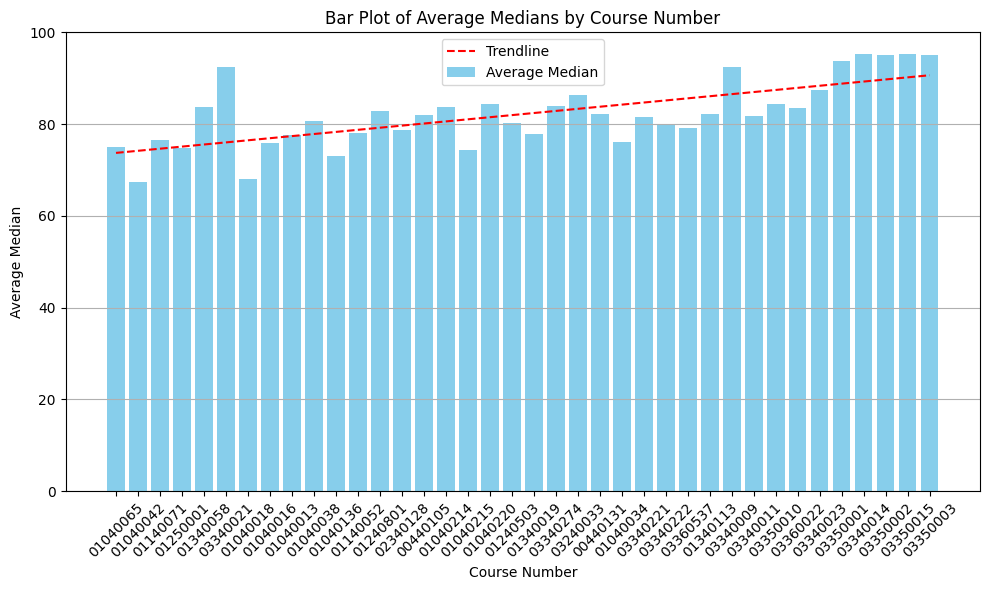

In [16]:
plot_bar_chart_with_trendline(calculate_average_median(hova2024), "average_medians_plot_2024.png")


In [23]:
averages = calculate_average_median(hova2024)
print(averages)

{'00440102': None, '01040065': 75.0, '01040042': 67.33, '01140071': 76.43, '01250001': 74.76, '01340058': 83.78, '03340021': 92.5, '01040018': 68.11, '01040016': 75.95, '01040013': 77.54, '01040038': 80.7, '01040136': 73.0, '01140052': 78.05, '01240801': 82.95, '02340128': 78.77, '00440105': 82.07, '01040214': 83.67, '01040215': 74.37, '01040220': 84.33, '01240503': 80.14, '01340019': 77.95, '03340274': 84.0, '03240033': 86.45, '00440131': 82.21, '01040034': 76.19, '03340221': 81.55, '03340222': 79.9, '03360537': 79.1, '01340113': 82.1, '03340009': 92.5, '03340011': 81.79, '03350010': 84.39, '03360022': 83.61, '03340023': 87.5, '03350001': 93.81, '03340014': 95.25, '03350002': 95.14, '03360026': None, '03350015': 95.25, '03350003': 95.12}


In [25]:
points = {'00440102': None,
 '01040065': 5.0,
 '01040042': 5.0,
 '01140071': 3.5,
 '01250001': 3.0,
 '01340058': 3.0,
 '03340021': 1.0,
 '01040018': 5.0,
 '01040016': 5.0,
 '01040013': 5.5,
 '01040038': 2.5,
 '01040136': 4.0,
 '01140052': 3.5,
 '01240801': 2.5,
 '02340128': 4.0,
 '00440105': 4.0,
 '01040214': 2.5,
 '01040215': 2.5,
 '01040220': 2.5,
 '01240503': 2.5,
 '01340019': 2.5,
 '03340274': 2.0,
 '03240033': 3.0,
 '00440131': 5.0,
 '01040034': 3.5,
 '03340221': 2.5,
 '03340222': 4.0,
 '03360537': 3.0,
 '01340113': 3.5,
 '03340009': 4.0,
 '03340011': 4.0,
 '03350010': 3.0,
 '03360022': 2.5,
 '03340023': 3.5,
 '03350001': 3.5,
 '03340014': 2.0,
 '03350002': 4.0,
 '03360026': None,
 '03350015': 3.0,
 '03350003': 2.0}

In [28]:
import re

text_data = """
3360020 ויב תועפות - תוילמשח 2 1 - 2.5
3360207 )ר"תע( תויאופר תונומת דוביע 2 2 - 3.0
3360208 םייגולויב תותוא לש הזילנאב תוטיש 2 2 - 3.0
3360326 םירטמרפ ךורעשו םינותנ חותינ 2 1 - 2.5
3360502 הימדה תונורקע 2 1 - 2.5
3360522 ויב תוכרעמב הרקבל אובמ - תויאופר 2 2 - 3.0
3360028 ב הקומע הדימל -MRI 2 - - 2.0
3360209 םייגולויזיפ תותואל הקומע הדימל 2 1 2.5
3360325 האופרב דנואסארטלוא 2 1 - 2.5
3360404 םיינורטקלאויב םיקשממ 2 1 - 2.5
3360504 תיטנגמ הדוהת תונורקע 2 - - 2.0
3360521 וידרקה 'עמ לש םייסדנה תונורקע 3 1 - 3.5
3360536 בצעה יעדמב תוטיש 2 1 - 2.5
3360538 ויב תונורקע - תולוקלומ תשיחל םייסדנה 2 1 - 2.5
3360540 בשחוממ יאופר רושכמ ןכת 2 1 - 2.5
3360544 םייטנג םילגעמ 2 1 - 2.5
3360545 היפרתוידרו תיניערג האופר 2 - - 2.0
3360546 תואירבה םוחתב תודמול תוכרעמ 2 1 2 3.0
3360547 יבושיח יטפוא תומיד 2 1 - 2.5
3360549 ףוציר תוקינכט DNA 2 2 - 3.0
3360550 תיבושיח הקיזיפויב 2 1 - 2.5
0340033 'מ תירמונ הזילנא 2 2 - 3.0
0440101 הנכת תוכרעמל אובמ 2 1 - 3.0
0440198 אובמ תותוא לש יתרפס דוביעל 2 1 - 3.0
0440202 םייארקא תותוא 2 1 - 3.0
0460195 תודמול תוכרעמ 2 1 - 3.0
0460197 בושיח תוטיש תוי היצזימיטפואב 2 1 - 3.0
0460200 תונומת חותינו דוביע 2 1 - 3.0
0460201 םייארקא תותוא דוביע 2 1 - 3.0
0460211 הקומע הדימל 2 1 1 3.0
0460332 העימשו היאר תוכרעמ 2 1 - 3.0
0460745 תותוא לש יתרפס דוביע 2 1 - 3.0
0460746 תבשחוממ הייארב םימושייו 'תירוגלא 2 1 - 3.0
2360523 הקיטמרופניאויבל אובמ 2 1 - 2.5
2360781 םייבושיח םיציאמ לע הקומע הדימל 2 1 1 3.0

Biomechanics:
3360326 םירטמרפ ךורעשו םינותנ חותינ 2 1 - 2.5
3360506 תימוקיש הקינכמויב 2 1 - 2.5
3360517 ויב - אתה לש הסדנה 2 1 - 2.5
3360522 ויב תוכרעמב הרקבל אובמ - תויאופר 2 2 - 3.0
3360539 המישנה תוכרעמב המירז 2 1 - 2.5
3360541 תירלוקסווידרקה תכרעמב המירז 2 1 - 2.5
3360021 וננ - יגולואירו הקינכמ 'לויבב םיקיקלח 2 1 - 2.5
3360520 המקר יפילחתו םיידפוטרוא םילתש 2 1 - 2.5
3360521 וידרקה 'עמ לש םייסדנה תונורקע 3 1 - 3.5
3360540 בשחוממ יאופר רושכמ ןכת 2 1 - 2.5
3360549 ףוציר תוקינכט DNA 2 2 - 3.0
3360550 תיבושיח הקיזיפויב 2 1 - 2.5
0340033 'מ תירמונ הזילנא 2 2 - 3.0
0350001 הקיטובורל אובמ 2 1 - 2.5
0350199 המירזה תרותב בשחמה שומיש 2 2 - 3.0
0360049 הקיטסונגאידו הרקבל תויבצע תותשר 2 1 - 2.5
0360072 הקיטובורו הקינכמויבב הקיטמטניק 3 - - 3.0
0360076 וננב הקיטניק ורטקלא - ורקימו - המירז 3 - - 3.0
0360086 נורקימ םינקתהב רבעמ תועפותו המירז 2 1 1 3.0
0360090 םיאת לש תינכמ השיחו הקינכמויב 3 -- - 3.0
0840225 הקימניד 3 2 - 4.0
2360332 םירבדה לש טנרטניאה - תויגולונכט 2 - - 2.0
2360333 םירבדה לש טנרטניאב טקיורפ 2 - 4 3.0

Biophysics:
3360020 ויב תועפות - תוילמשח 2 1 - 2.5
3360023 ויב הקיטפוא ימושיי - תיאופר 2 1 - 2.5
3360326 םירטמרפ ךורעשו םינותנ חותינ 2 1 - 2.5
3360533 הקינוטופו הקיטפוא 2 2 - 3.0
3360538 ויב תונורקע - תולוקלומ תשיחל םייסדנה 2 1 - 2.5
3360550 תיבושיח הקיזיפויב 2 1 - 2.5
3360021 וננ - היגולויבב םיקיקלח 2 1 - 2.5
3360028 ב הקומע הדימל -MRI 2 - - 2.0
3360325 האופרב דנואסארטלוא 2 1 - 2.5
3360402 ויב ןכת - םירמוח 2 1 - 2.5
3360404 םיינורטקלאויב םיקשממ 2 1 - 2.5
3360502 הימדה תונורקע 2 1 - 2.5
3360504 תיטנגמ הדוהת תונורקע 2 - - 2.0
3360521 תונורקע וידרקה 'עמ לש םייסדנה 3 1 - 3.5
3360536 בצעה יעדמב תוטיש 2 1 - 2.5
3360545 היפרתוידרו תיניערג האופר 2 - - 2.0
3360547 יבושיח יטפוא תומיד 2 1 - 2.5
3360549 ףוציר תוקינכט DNA 2 2 - 3.0
0360090 םייגולויב םיאת י"ע תינכמ השיח 3 - - 3.0
0440198 אובמ יתרפס דוביעל 2 1 - 3.0
0460211 הקומע הדימל 2 1 1 3.0
0640250 ויב לש היגולונכטו עדמ - םירמוח 2 2 - 3.0
1140036 תימרתו תיטסיטטס הקיזיפ 4 2 - 5.0
1160321 אתה לש הקיזיפויב 3 - - 3.0
1250000 םיסדנהמל תיטנווק הימיכל אובמ 3 1 1 4.0
1260304 תינבמ היגולויב 2 2 - 2.0
1340082 תירלוקלומ היגולויב 2 1 - 2.5
1340119 יטנגה יוטיבה תרקב 2 1 - 2.5
1340141 תיבושיח היגולויב 2 1 - 2.5
1340156 תירלוקלומ הקיזיפויב 3 - - 3.0

Tissue:
3360021 וננ - יגולואירו הקינכמ 'לויבב םיקיקלח 2 1 - 2.5
3360402 ויב ןכת - םירמוח 2 1 - 2.5
3360517 ויב - אתה לש הסדנה 2 1 - 2.5
3360528 תופורת לש רקובמ רורחש 2 1 - 2.5
3360529 םייגולויב םיפילחתו תומקר תסדנה 2 1 - 2.5
3360326 םירטמרפ ךורעשו םינותנ חותינ 2 1 - 2.5
3360404 םיינורטקלאויב םיקשממ 2 1 - 2.5
3360405 כטויבבו היגולויבב םייסדנה תודוסי 'נ 2 1 - 2.5
3360520 םילתש המקר יפילחתו םיידפוטרוא 2 1 - 2.5
3360521 וידרקה 'עמ לש םייסדנה תונורקע 3 1 - 3.5
3360538 ויב תונורקע - תולוקלומ תשיחל םייסדנה 2 1 - 2.5
3360544 םייטנג םילגעמ 2 1 - 2.5
3360548 םייטנג םילגעמ ןכתל הדבעמ - - 4 2.0
3360549 ףוציר תוקינכט DNA 2 2 - 3.0
3360550 תיבושיח הקיזיפויב 2 1 - 2.5
0540413 היגולונכטויבב םהימושיו םירמילופ 2 1 - 2.5
0660333 ויב - תוחקור 2 1 - 2.5
0660121 תיאופר הקיטסונגאיד 2 2 - 3.0
1340020 תיללכ הקיטנג 3 1 - 3.5
1340069 תוחתפתהה לש היגולויב 2 1 - 2.5
1340082 תירלוקלומ היגולויב 2 1 - 2.5
1340119 יטנגה יוטיבה תרקב 2 1 - 2.5
1340121 היגולוריוו היגולויבורקימ 3 - - 3.0
2760413 תיסיסב היגולונומיא 3 - - 3.0
"""

# Initialize the dictionaries
imaging = {}
biomechanics = {}
biophysics = {}
tissue = {}

# Current category being processed
current_category = None

# Split the text into lines
lines = text_data.strip().split('\n')

for line in lines:
    line = line.strip()

    # Skip empty lines
    if not line:
        continue

    # Check for category headers
    if line == "Biomechanics:":
        current_category = biomechanics
        continue
    elif line == "Biophysics:":
        current_category = biophysics
        continue
    elif line == "Tissue:":
        current_category = tissue
        continue
    # The first block of courses without a header is 'Imaging'
    elif current_category is None and not re.match(r'^\d+', line): # If no category set and line is not a course number, assume it's the start of imaging
        current_category = imaging
        # No continue here, as the line itself might be the first course in imaging
    elif current_category is None: # If it's the very first line and it's a course, it belongs to imaging
        current_category = imaging


    # Extract course number and points if a category is active
    if current_category is not None:
        # Regex to find the course number (first group of digits) and the points (last float)
        match = re.search(r'(\d+).*?(\d+\.\d+)$', line)
        if match:
            course_number = match.group(1)
            points_str = match.group(2)
            course_number = '0' + course_number

            try:
                points = float(points_str)
                current_category[course_number] = points
            except ValueError:
                print(f"Warning: Could not parse points for line: {line}")
        else:
            # This handles cases where a line might not contain a course number and points
            # but isn't a category header (e.g., empty lines within a category, or other descriptive text)
            pass # Silently ignore lines that don't match the pattern

print("imaging =", imaging)
print("\nbiomechanics =", biomechanics)
print("\nbiophysics =", biophysics)
print("\ntissue =", tissue)


imaging = {'03360020': 2.5, '03360207': 3.0, '03360208': 3.0, '03360326': 2.5, '03360502': 2.5, '03360522': 3.0, '03360028': 2.0, '03360209': 2.5, '03360325': 2.5, '03360404': 2.5, '03360504': 2.0, '03360521': 3.5, '03360536': 2.5, '03360538': 2.5, '03360540': 2.5, '03360544': 2.5, '03360545': 2.0, '03360546': 3.0, '03360547': 2.5, '03360549': 3.0, '03360550': 2.5, '00340033': 3.0, '00440101': 3.0, '00440198': 3.0, '00440202': 3.0, '00460195': 3.0, '00460197': 3.0, '00460200': 3.0, '00460201': 3.0, '00460211': 3.0, '00460332': 3.0, '00460745': 3.0, '00460746': 3.0, '02360523': 2.5, '02360781': 3.0}

biomechanics = {'03360326': 2.5, '03360506': 2.5, '03360517': 2.5, '03360522': 3.0, '03360539': 2.5, '03360541': 2.5, '03360021': 2.5, '03360520': 2.5, '03360521': 3.5, '03360540': 2.5, '03360549': 3.0, '03360550': 2.5, '00340033': 3.0, '00350001': 2.5, '00350199': 3.0, '00360049': 2.5, '00360072': 3.0, '00360076': 3.0, '00360086': 3.0, '00360090': 3.0, '00840225': 4.0, '02360332': 2.0, '02

In [32]:
print("Processing Imaging courses:")
imaging_course_numbers = list(imaging.keys())
imaging = get_finals_statistics(imaging_course_numbers, access_token)
ave_imaging = calculate_average_median(imaging)

print("\nProcessing Biomechanics courses:")
biomechanics_course_numbers = list(biomechanics.keys())
biomech = get_finals_statistics(biomechanics_course_numbers, access_token)
ave_biomech = calculate_average_median(biomech)

print("\nProcessing Biophysics courses:")
biophysics_course_numbers = list(biophysics.keys())
biophys = get_finals_statistics(biophysics_course_numbers, access_token)
ave_biophys = calculate_average_median(biophys)

print("\nProcessing Tissue courses:")
tissue_course_numbers = list(tissue.keys())
tissue = get_finals_statistics(tissue_course_numbers, access_token)
ave_tissue = calculate_average_median(tissue)

Processing Imaging courses:


 23%|██▎       | 8/35 [00:09<00:25,  1.04it/s]

Error fetching data for course 03360209: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/03360209?ref=main


100%|██████████| 35/35 [01:06<00:00,  1.90s/it]



Processing Biomechanics courses:


 74%|███████▍  | 17/23 [00:17<00:06,  1.02s/it]

Error fetching data for course 00360072: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/00360072?ref=main


 83%|████████▎ | 19/23 [00:18<00:03,  1.27it/s]

Error fetching data for course 00360086: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/00360086?ref=main


100%|██████████| 23/23 [00:28<00:00,  1.22s/it]



Processing Biophysics courses:


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]



Processing Tissue courses:


 75%|███████▌  | 18/24 [00:13<00:03,  1.53it/s]

Error fetching data for course 00660121: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/00660121?ref=main


100%|██████████| 24/24 [00:26<00:00,  1.09s/it]


In [ ]:
ave_tissue

AttributeError: 'dict' object has no attribute 'max'

In [26]:
# Course numbers to be dropped from the averages calculation
courses_to_drop = ['03240033', '01040018', '01040016']

# Initialize variables for weighted sum and total points
weighted_sum = 0.0
total_points = 0.0

# Iterate through the averages dictionary
for course_number, average in averages.items():
    # Check if the course number should be dropped or if its average is None
    if course_number in courses_to_drop or average is None:
        continue

    # Ensure the course number is a string for consistent key lookup
    course_number_str = str(course_number)

    # Check if the course number exists in the points dictionary
    if course_number_str in points:
        course_points = points[course_number_str]

        # Only include courses with non-zero points in the calculation
        if course_points > 0:
            weighted_sum += (average * course_points)
            total_points += course_points

# Calculate the final weighted average
final_weighted_average = 0.0
if total_points > 0:
    final_weighted_average = weighted_sum / total_points

print(f"The final calculated weighted average is: {final_weighted_average:.2f}")


The final calculated weighted average is: 81.82


We can't conclude much from that stats, but we can debate about that :)

Now i'm gonna find out which course had an exam that no one could ace

In [13]:
def get_max_statistics(course_numbers, access_token):
    """
    Fetches the maximum grade statistics for the given course numbers from GitHub,
    considering "Exam_A.json" and "Exam_B.json", excluding grades of 100.

    Args:
        course_numbers (list of str): List of course numbers to fetch statistics for.
        access_token (str): GitHub access token for authentication.

    Returns:
        dict: A dictionary containing the maximum grade statistics for each course.
    """
    statistics = {}
    base_url = "https://api.github.com/repos/michael-maltsev/technion-histograms/contents/"
    headers = {'Authorization': f'token {access_token}'}

    for course_number in tqdm(course_numbers):
        course_url = f"{base_url}{course_number}?ref=main"
        try:
            response = requests.get(course_url, headers=headers)
            response.raise_for_status()
            folders = response.json()

            course_statistics = {"Exam_A": {}, "Exam_B": {}}
            for folder in folders:
                if folder['type'] == 'dir':
                    folder_name = folder['name']
                    for exam in ["Exam_A.json", "Exam_B.json"]:
                        exam_key = exam.split('.')[0]  # Either "Exam_A" or "Exam_B"
                        exam_url =f"https://raw.githubusercontent.com/michael-maltsev/technion-histograms/main/{course_number}/{folder_name}/{exam}"
                        response = requests.get(exam_url, headers=headers)
                        if response.status_code == 200:
                            exam_data = response.json()
                            max_grade = exam_data.get("max")
                            if max_grade and max_grade != 100:
                                if folder_name not in course_statistics[exam_key]:
                                    course_statistics[exam_key][folder_name] = max_grade
                                else:
                                    course_statistics[exam_key][folder_name] = max(max_grade, course_statistics[exam_key][folder_name])
            statistics[course_number] = course_statistics
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for course {course_number}: {e}")
    sleep(0.2)
    return statistics

def write_max_statistics_to_csv(statistics, filename):
    """
    Writes the maximum grade statistics to a CSV file.

    Args:
        statistics (dict): A dictionary containing the maximum grade statistics for each course.
        filename (str): The name of the CSV file to be created.
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Course Number", "Folder", "Exam", "Max Grade"])

        for course_number, exams in statistics.items():
            # Get all unique folders
            all_folders = set()
            for exam_key, folders in exams.items():
                all_folders.update(folders.keys())
            
            # Write data for each folder
            for folder_name in all_folders:
                for exam_key in ['Exam_A', 'Exam_B']:
                    if exam_key in exams and folder_name in exams[exam_key]:
                        max_grade = exams[exam_key][folder_name]
                        writer.writerow([course_number, folder_name, exam_key, max_grade])


In [ ]:
write_max_statistics_to_csv(get_max_statistics(find_6_digit_sequences(clean_string(catalog['mechonot'])), access_token), "MechMax.csv")

 79%|███████████████████████████████████████████████████████████████▎                | 34/43 [08:53<01:05,  7.24s/it]

Error fetching data for course 034057: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/034057?ref=main


 91%|████████████████████████████████████████████████████████████████████████▌       | 39/43 [09:22<00:19,  4.93s/it]

Error fetching data for course 034382: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/034382?ref=main


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [09:39<00:00, 13.47s/it]


<IPython.core.display.Javascript object>